In [1]:
import time
import pandas as pd
import requests
import os
from dotenv import load_dotenv
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from lxml import html
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from datetime import datetime
import pytz
import urllib.parse
import json
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

import matplotlib
import numpy as np
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 50  # 设置限制为 50 MB
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 数据收集

In [2]:
load_dotenv()

True

In [3]:
headers = {
    "accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "accept-encoding":"gzip, deflate, br, zstd",
    "accept-language":"zh-CN,zh;q=0.9,en;q=0.8",
    "cache-control":"max-age=0",
    "cookie": os.getenv("BILIBILI_COOKIE"),
    "priority":"u=0, i",
    "sec-ch-ua":'''"Chromium";v="136", "Google Chrome";v="136", "Not.A/Brand";v="99"''',
    "sec-ch-ua-mobile":"?0",
    "sec-ch-ua-platform":'''"Windows"''',
    "sec-fetch-dest":"document",
    "sec-fetch-mode":"navigate",
    "sec-fetch-site":"none",
    "sec-fetch-user":"?1",
    "upgrade-insecure-requests":"1",
    "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36"
}

In [4]:
class ProxyPool:
    def __init__(self, auth_key=os.getenv('AUTH_KEY'), 
                 password=os.getenv('AUTH_PASSWORD'), 
                 max_proxies=20, 
                 min_proxies=5):
        self.auth_key = auth_key
        self.password = password
        self.max_proxies = max_proxies
        self.min_proxies = min_proxies
        self.proxy_pool = []
        self.lock = False
        self.test_url = "https://test.ipw.cn"
        
    def fetch_proxies(self, num=5):
        if self.lock:
            return []
            
        self.lock = True
        try:
            url = f"https://share.proxy.qg.net/get?key={self.auth_key}&num={num}"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                proxy_data = response.json()
                if proxy_data.get('data'):
                    new_proxies = [{
                        'server': proxy['server'],
                        'proxy_url': f"http://{self.auth_key}:{self.password}@{proxy['server']}"
                    } for proxy in proxy_data['data']]
                    return new_proxies
            return []
        except Exception as e:
            print(f"获取代理失败: {e}")
            return []
        finally:
            self.lock = False
    
    def add_proxies(self, proxies):
        existing_servers = {p['server'] for p in self.proxy_pool}
        for proxy in proxies:
            if proxy['server'] not in existing_servers:
                self.proxy_pool.append(proxy)
                existing_servers.add(proxy['server'])
                
        while len(self.proxy_pool) > self.max_proxies:
            self.proxy_pool.pop(random.randint(0, len(self.proxy_pool)-1))
    
    def check_and_refill(self):
        if len(self.proxy_pool) < self.min_proxies:
            needed = self.max_proxies - len(self.proxy_pool)
            new_proxies = self.fetch_proxies(min(needed, 10))
            if new_proxies:
                self.add_proxies(new_proxies)
                print(f"已补充 {len(new_proxies)} 个新代理")
    
    def get_proxy(self):
        self.check_and_refill()
        if not self.proxy_pool:
            return None
        return random.choice(self.proxy_pool)
    
    def remove_proxy(self, proxy):
        if proxy in self.proxy_pool:
            self.proxy_pool.remove(proxy)
    
    def validate_proxy(self, proxy, timeout=5):
        try:
            proxies = {
                "http": proxy['proxy_url'],
                "https": proxy['proxy_url']
            }
            response = requests.get(self.test_url, proxies=proxies, timeout=timeout)
            return response.status_code == 200
        except:
            return False
    
    def auto_maintain(self, interval=300):
        while True:
            with ThreadPoolExecutor(max_workers=10) as executor:
                results = list(executor.map(self.validate_proxy, self.proxy_pool))
            
            valid_proxies = [p for p, valid in zip(self.proxy_pool, results) if valid]
            removed = len(self.proxy_pool) - len(valid_proxies)
            if removed > 0:
                print(f"移除了 {removed} 个无效代理")
            self.proxy_pool = valid_proxies
            
            self.check_and_refill()
            time.sleep(interval)

    def get_proxies_for_requests(self, proxy):
        if not proxy:
            return None
        return {
            "http": proxy['proxy_url'],
            "https": proxy['proxy_url']
        }

In [5]:
class BilibiliCrawler:

    COLUMNS = [
        'date_name', 'aid', 'tid', 'tname', 'title', 'duration',
        'owner_mid', 'owner_name', 'view', 'danmaku', 'reply',
        'favorite', 'coin', 'share', 'like', 'short_link',
        'pub_location', 'pubdate', 'rcmd_reason', 'desc'
    ]

    def __init__(self, proxy_pool):
        self.proxy_pool = proxy_pool
        self.headers = headers.copy()
        self.df_lst = []
        self.complete_pages = []
        self.error_page = []
        self.lock = threading.Lock()
        
    def fetch_data(self, page):
        url = f"https://api.bilibili.com/x/web-interface/popular/series/one?number={page}"
        
        max_retries = 10
        retry_count = 0
        
        while retry_count < max_retries:
            proxy = self.proxy_pool.get_proxy()
            if not proxy:
                print(f"Page {page}: 没有可用代理")
                return False
                
            try:
                proxies = self.proxy_pool.get_proxies_for_requests(proxy)
                response = requests.get(url, headers=self.headers, proxies=proxies, timeout=10)
                data = response.json()
                
                if data.get('code') == 0 and 'data' in data and 'list' in data.get('data', {}):
                    data_list = data['data']['list']
                    data_config = data['data']['config']
                    
                    date_name = data_config.get('name')
                    
                    page_data = []
                    for item in data_list:
                        tmp = []
                        tmp.append(date_name)                                  
                        tmp.append(item.get('aid', None))                      
                        tmp.append(item.get('tid', None))                       
                        tmp.append(item.get('tname', None))                     
                        tmp.append(item.get('title', None))                    
                        tmp.append(item.get('duration', None))                
                        owner = item.get('owner', {})
                        tmp.append(owner.get('mid', None))                    
                        tmp.append(owner.get('name', None))                    
                        stat = item.get('stat', {})
                        tmp.append(stat.get('view', None))                     
                        tmp.append(stat.get('danmaku', None))                  
                        tmp.append(stat.get('reply', None))                    
                        tmp.append(stat.get('favorite', None))                
                        tmp.append(stat.get('coin', None))                    
                        tmp.append(stat.get('share', None))                   
                        tmp.append(stat.get('like', None))                    
                        tmp.append(item.get('short_link_v2', None))            
                        tmp.append(item.get('pub_location', None))            
                        tmp.append(item.get('pubdate', None))                 
                        tmp.append(item.get('rcmd_reason', None))  
                        tmp.append(item.get('desc', None))              

                        page_data.append(tmp)
                    
                    with self.lock:
                        self.df_lst.extend(page_data)
                        self.complete_pages.append(page)
                    
                    print(f"✅ 成功获取第 {page} 页数据，共 {len(page_data)} 条记录")
                    return True
                
                else:
                    print(f"Page {page}: 数据获取失败 - {data.get('message', 'Unknown error')}")
                    self.proxy_pool.remove_proxy(proxy)
                    retry_count += 1
                    
            except Exception as e:
                print(f"Page {page}: 请求异常 - {str(e)}")
                self.proxy_pool.remove_proxy(proxy)
                retry_count += 1
        
        print(f"Page {page}: 达到最大重试次数 {max_retries} 次，放弃")
        with self.lock:
            self.error_page.append(page)
        return False
    
    def run_concurrent_crawler(self, 
                               start_page, 
                               end_page, 
                               num_threads=5):
        print(f"\n开始多线程爬取，页码范围: {start_page}-{end_page}，线程数: {num_threads}\n")
        
        success_count = 0
        fail_count = 0
        
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = {executor.submit(self.fetch_data, page): page for page in range(start_page, end_page+1)}
            
            for future in as_completed(futures):
                page = futures[future]
                try:
                    result = future.result()
                    if result:
                        success_count += 1
                    else:
                        fail_count += 1
                except Exception as e:
                    print(f"Page {page}: 线程执行异常 - {str(e)}")
                    fail_count += 1
        
        print(f"\n爬取完成 - 成功: {success_count} 失败: {fail_count} 成功率: {success_count/(success_count+fail_count)*100:.1f}%")

    def save_to_csv(self, filename="bilibili_popular.csv"):
        if not self.df_lst:
            print("没有数据可保存")
            return False
        
        try:
            os.makedirs('./data', exist_ok=True)
            df = pd.DataFrame(self.df_lst, columns=self.COLUMNS)
            df = df.drop_duplicates(subset='aid', keep='first')
            filepath = f"./data/{filename}"
            df.to_csv(filepath, index=True, encoding='utf_8_sig')
            
            print(f"数据已成功保存到 {filepath}")
            return True
        except Exception as e:
            print(f"保存文件时出错: {str(e)}")
            return False

        

In [6]:
def get_newest_page():
    url = "https://api.bilibili.com/x/web-interface/popular/series/list"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if data.get('code') == 0 and data.get('data', {}).get('list', []):
            newest_page = data['data']['list'][0].get('number', 1)
            return newest_page
    else:
        print(f"Error fetching newest page: {data.get('message', 'Unknown error')}")
        return None

In [7]:
proxy_pool = ProxyPool(auth_key=os.getenv('AUTH_KEY'), password=os.getenv('AUTH_PASSWORD'))

initial_proxies = proxy_pool.fetch_proxies(10)
proxy_pool.add_proxies(initial_proxies)
print(f"初始代理数量: {len(proxy_pool.proxy_pool)}")

maintain_thread = threading.Thread(target=proxy_pool.auto_maintain, daemon=True)
maintain_thread.start()

crawler = BilibiliCrawler(proxy_pool)

mmax_page, batch = get_newest_page(), 50
for i in range(mmax_page // batch + 1):
    crawler.run_concurrent_crawler(start_page=i*batch+1, 
                                    end_page=min((i+1)*batch, mmax_page), 
                                    num_threads=10)
    time.sleep(5)   


try:
    while True:
        if len(crawler.complete_pages) == mmax_page:
            break
        time.sleep(1)
except KeyboardInterrupt:
    print("\n程序退出")

初始代理数量: 10

开始多线程爬取，页码范围: 1-50，线程数: 10

✅ 成功获取第 5 页数据，共 13 条记录
✅ 成功获取第 3 页数据，共 13 条记录
✅ 成功获取第 2 页数据，共 15 条记录
✅ 成功获取第 4 页数据，共 14 条记录
✅ 成功获取第 1 页数据，共 10 条记录
✅ 成功获取第 6 页数据，共 12 条记录
✅ 成功获取第 9 页数据，共 14 条记录
✅ 成功获取第 10 页数据，共 13 条记录
✅ 成功获取第 7 页数据，共 12 条记录
✅ 成功获取第 13 页数据，共 12 条记录
✅ 成功获取第 11 页数据，共 13 条记录
✅ 成功获取第 14 页数据，共 13 条记录
✅ 成功获取第 12 页数据，共 11 条记录
✅ 成功获取第 15 页数据，共 11 条记录
✅ 成功获取第 16 页数据，共 13 条记录
✅ 成功获取第 17 页数据，共 13 条记录
✅ 成功获取第 19 页数据，共 13 条记录
✅ 成功获取第 8 页数据，共 11 条记录
✅ 成功获取第 18 页数据，共 12 条记录
✅ 成功获取第 22 页数据，共 14 条记录
✅ 成功获取第 23 页数据，共 17 条记录
✅ 成功获取第 24 页数据，共 12 条记录
✅ 成功获取第 26 页数据，共 18 条记录
✅ 成功获取第 21 页数据，共 12 条记录
✅ 成功获取第 20 页数据，共 12 条记录
✅ 成功获取第 29 页数据，共 23 条记录
✅ 成功获取第 25 页数据，共 23 条记录
✅ 成功获取第 27 页数据，共 22 条记录
✅ 成功获取第 28 页数据，共 25 条记录
移除了 2 个无效代理
✅ 成功获取第 39 页数据，共 23 条记录
✅ 成功获取第 30 页数据，共 24 条记录
✅ 成功获取第 38 页数据，共 16 条记录
✅ 成功获取第 32 页数据，共 16 条记录
✅ 成功获取第 37 页数据，共 18 条记录
✅ 成功获取第 33 页数据，共 22 条记录
✅ 成功获取第 35 页数据，共 23 条记录
✅ 成功获取第 36 页数据，共 18 条记录
✅ 成功获取第 40 页数据，共 21 条记录
✅ 成功获取第 44 页数据，共 23 条记录
✅ 成功获取第 45 页数据，共 25 条

移除了 10 个无效代理
已补充 10 个新代理


In [8]:
crawler.save_to_csv()

数据已成功保存到 ./data/bilibili_popular.csv


True

## 数据处理

In [9]:
df = pd.read_csv("./data/bilibili_popular.csv", encoding='utf_8_sig')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11641 entries, 0 to 11640
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    11641 non-null  int64 
 1   date_name     11641 non-null  object
 2   aid           11641 non-null  int64 
 3   tid           11641 non-null  int64 
 4   tname         11641 non-null  object
 5   title         11641 non-null  object
 6   duration      11641 non-null  int64 
 7   owner_mid     11641 non-null  int64 
 8   owner_name    11641 non-null  object
 9   view          11641 non-null  int64 
 10  danmaku       11641 non-null  int64 
 11  reply         11641 non-null  int64 
 12  favorite      11641 non-null  int64 
 13  coin          11641 non-null  int64 
 14  share         11641 non-null  int64 
 15  like          11641 non-null  int64 
 16  short_link    11641 non-null  object
 17  pub_location  7659 non-null   object
 18  pubdate       11641 non-null  int64 
 19  rcmd

In [10]:
# 获取分区 将tag归为大的分区
# 需开启代理 否则国内访问github会被限制
chrome_options = Options()
chrome_options.add_argument("--headless")  
driver = webdriver.Chrome(options=chrome_options)

url = "https://github.com/SocialSisterYi/bilibili-API-collect/blob/master/docs/video/video_zone.md"
driver.get(url)
time.sleep(2)  

html_content = driver.page_source

tree = html.fromstring(html_content)
class_dict = {}

for i in range(2, 24):
    xpath = f'//*[@id="repo-content-pjax-container"]/react-app/div/div/div[1]/div/div/div[2]/div/div/div[3]/div[2]/div/div[3]/section/div/article'
    main_xpath = f'{xpath}/div[{i}]/h2/text()'
    class_fa = tree.xpath(main_xpath)[0].strip()
    sub_xpath = f'{xpath}/markdown-accessiblity-table[{i-1}]/table/tbody/tr'
    sub_elements = tree.xpath(sub_xpath)
    for sub_element in sub_elements:
        try:
            class_son_id = sub_element.xpath('td[3]/text()')[0].strip()
        except IndexError:
            class_son_id = sub_element.xpath('td[3]/del/text()')[0].strip()
        if class_dict.get(class_fa) is None:
            class_dict[class_fa] = []
        class_dict[class_fa].append(class_son_id)
driver.quit()

There was an error managing chromedriver (error sending request for url (https://googlechromelabs.github.io/chrome-for-testing/known-good-versions-with-downloads.json)); using driver found in the cache


In [11]:
# 处理重定向的id 即换过分区的tag
ids = []
for class_fa, class_son_ids in class_dict.items():
    for class_son_id in class_son_ids:
        if class_son_id not in ids:
            ids.append(class_son_id)
        else:
            print(f"重复的ID: {class_son_id} 在 {class_fa} 中")
to_remove = [176, 76, 75, 164]
for i in to_remove:
    if i in class_dict.get('生活', []):
        class_dict['生活'].remove(i)

重复的ID: 176 在 生活 中
重复的ID: 76 在 美食 中
重复的ID: 75 在 动物圈 中
重复的ID: 164 在 时尚 中


In [12]:
tid_to_fa = {}
for class_fa, tid_list in class_dict.items():
    for tid in tid_list:
        tid_to_fa[int(tid)] = class_fa
df['t_fa'] = df['tid'].map(tid_to_fa)
df.head(10)

unmapped_count = df['t_fa'].isna().sum()
if unmapped_count > 0:
    print(f"警告：有 {unmapped_count} 行的tid无法映射到父分类")
    print(f"未映射的tid值: {df[df['t_fa'].isna()]['tid'].unique()}")
else:
    print("所有tid都已成功映射到分区")
    
    df['t_fa'] = df['t_fa'].fillna("未分类")


所有tid都已成功映射到分区


In [13]:
# 将时间戳转化为日期格式
df['pudate'] = df['pubdate'].apply(lambda x: datetime.fromtimestamp(x, tz=pytz.timezone('Asia/Shanghai')).strftime('%Y-%m-%d'))

df.to_csv("./data/bilibili_popular.csv", index=False, encoding='utf_8_sig')
print("数据处理完成，已保存到 ./data/bilibili_popular.csv")

数据处理完成，已保存到 ./data/bilibili_popular.csv


## 数据分析

In [14]:
data = pd.read_csv("./data/bilibili_popular.csv", encoding='utf_8_sig')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11641 entries, 0 to 11640
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    11641 non-null  int64 
 1   date_name     11641 non-null  object
 2   aid           11641 non-null  int64 
 3   tid           11641 non-null  int64 
 4   tname         11641 non-null  object
 5   title         11641 non-null  object
 6   duration      11641 non-null  int64 
 7   owner_mid     11641 non-null  int64 
 8   owner_name    11641 non-null  object
 9   view          11641 non-null  int64 
 10  danmaku       11641 non-null  int64 
 11  reply         11641 non-null  int64 
 12  favorite      11641 non-null  int64 
 13  coin          11641 non-null  int64 
 14  share         11641 non-null  int64 
 15  like          11641 non-null  int64 
 16  short_link    11641 non-null  object
 17  pub_location  7659 non-null   object
 18  pubdate       11641 non-null  int64 
 19  rcmd

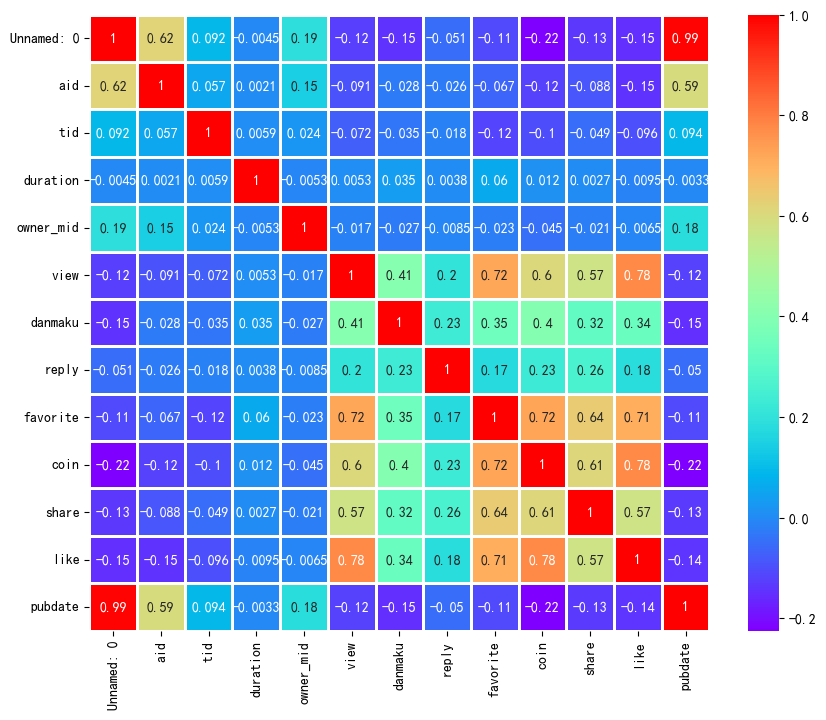

In [15]:
sns.heatmap(data.select_dtypes('number').corr(),annot=True,cmap='rainbow',linewidth=2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

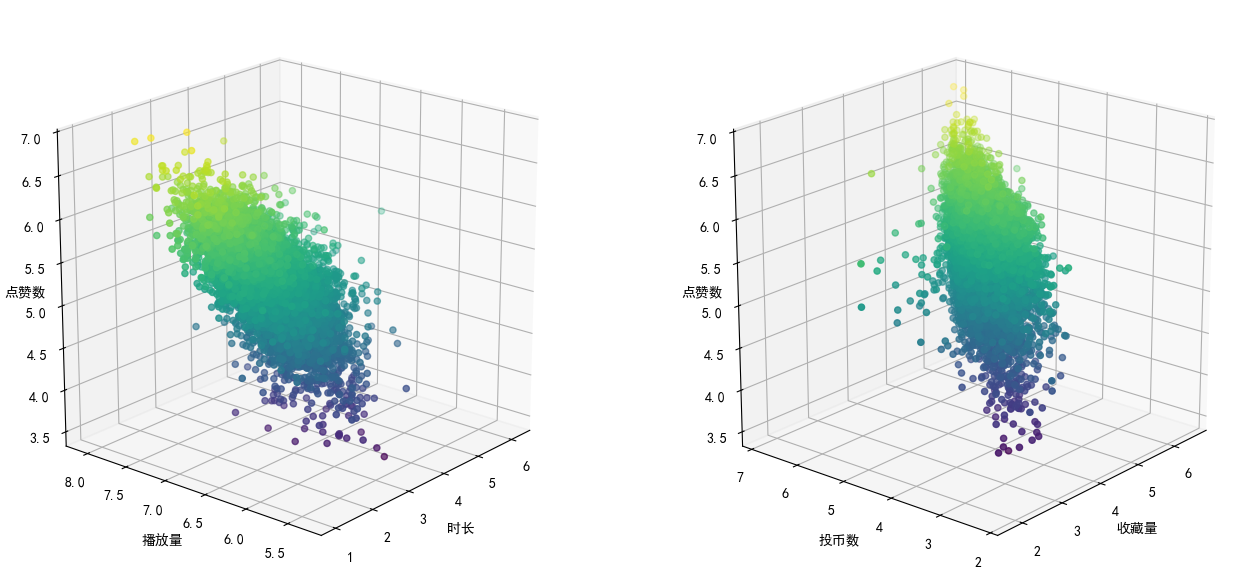

In [16]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(121, projection='3d')

x=data['duration']
y=data['view']
z=data['like']
x_log, y_log, z_log = np.log10(x), np.log10(y),np.log10(z)
color = z_log

ax.scatter3D(x_log, y_log, z_log,c=color, cmap='viridis')
ax.set_box_aspect([1, 1, 1])
ax.view_init(elev=20, azim=-140)
ax.set_xlabel('时长')
ax.set_ylabel('播放量')
ax.set_zlabel('点赞数',labelpad=-5)

ax = fig.add_subplot(122, projection='3d')

x=data['favorite']
y=data['coin']
z=data['like']
x_log, y_log, z_log = np.log10(x), np.log10(y),np.log10(z)
color = z_log

ax.scatter3D(x_log, y_log, z_log,c=color, cmap='viridis')
ax.set_box_aspect([1, 1, 1])
ax.view_init(elev=20, azim=-140)
ax.set_xlabel('收藏量')
ax.set_ylabel('投币数')
ax.set_zlabel('点赞数',labelpad=-5)

plt.show()

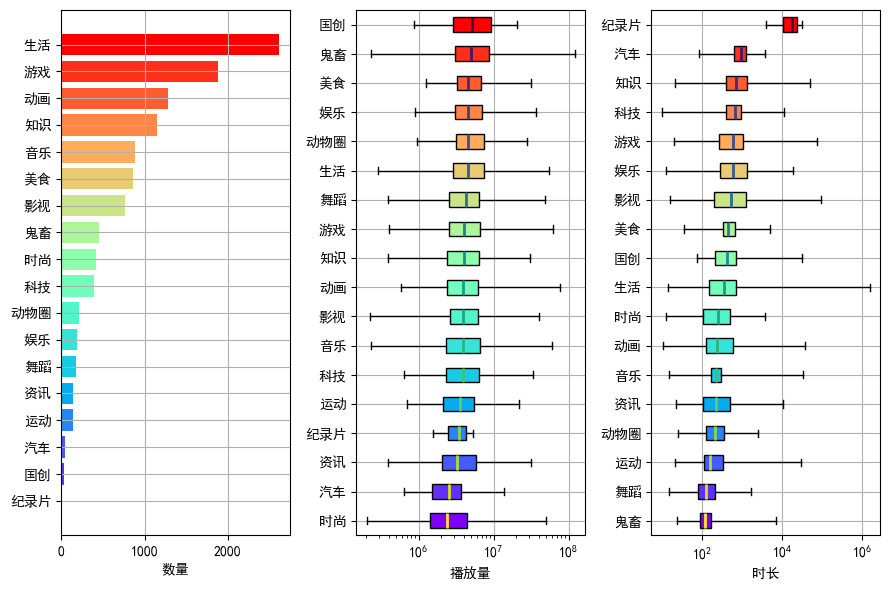

In [18]:
fig, ax = plt.subplots(1,3,figsize=(9, 6))

x=data.groupby('t_fa')['t_fa'].value_counts().sort_values()
colors = plt.cm.rainbow(np.linspace(0, 1, len(x)))
ax1 = ax[0]
ax1.barh(x.index,x,color=colors)
ax1.set_yticks(ticks=range(0, len(x.index)), labels=x.index)
ax1.set_xlabel('数量')
ax1.grid(True)

df = data.copy()
grouped_data = [df[df["t_fa"] == partition]["view"].values for partition in df["t_fa"].unique()]
sorted_indices = sorted(range(len(grouped_data)), key=lambda i: np.median(grouped_data[i]))
data.groupby("t_fa")["view"]
partitions = df["t_fa"].unique()
sorted_grouped_data = [grouped_data[i] for i in sorted_indices]
sorted_partitions = [partitions[i] for i in sorted_indices]
colors = plt.cm.rainbow(np.linspace(0, 1, len(partitions)))
colors2= plt.cm.viridis(np.linspace(1, 0, len(partitions)))
ax2 = ax[1]
bp = ax2.boxplot(sorted_grouped_data, vert=False, patch_artist=True,whis=30.0)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for median, color in zip(bp['medians'], colors2):
    median.set_color(color)
    median.set_linewidth(2)
ax2.set_xscale('log')
ax2.set_xlabel('播放量')
ax2.set_yticks(ticks=range(1, len(grouped_data) +1), labels=sorted_partitions)
ax2.grid(True)

df = data.copy()
grouped_data = [df[df["t_fa"] == partition]["duration"].values for partition in df["t_fa"].unique()]
sorted_indices = sorted(range(len(grouped_data)), key=lambda i: np.median(grouped_data[i]))
sorted_grouped_data = [grouped_data[i] for i in sorted_indices]
sorted_partitions = [partitions[i] for i in sorted_indices]
data.groupby("t_fa")["duration"]
partitions = df["t_fa"].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(partitions)))
colors2= plt.cm.viridis(np.linspace(1, 0, len(partitions)))
ax3 = ax[2]
bp = ax3.boxplot(sorted_grouped_data, vert=False, patch_artist=True,whis=10000.0)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for median, color in zip(bp['medians'], colors2):
    median.set_color(color)
    median.set_linewidth(2)
ax3.set_xscale('log')
ax3.set_xlabel('时长')
ax3.set_yticks(ticks=range(1, len(grouped_data) +1), labels=sorted_partitions)
ax3.grid(True)

plt.tight_layout()
plt.show()

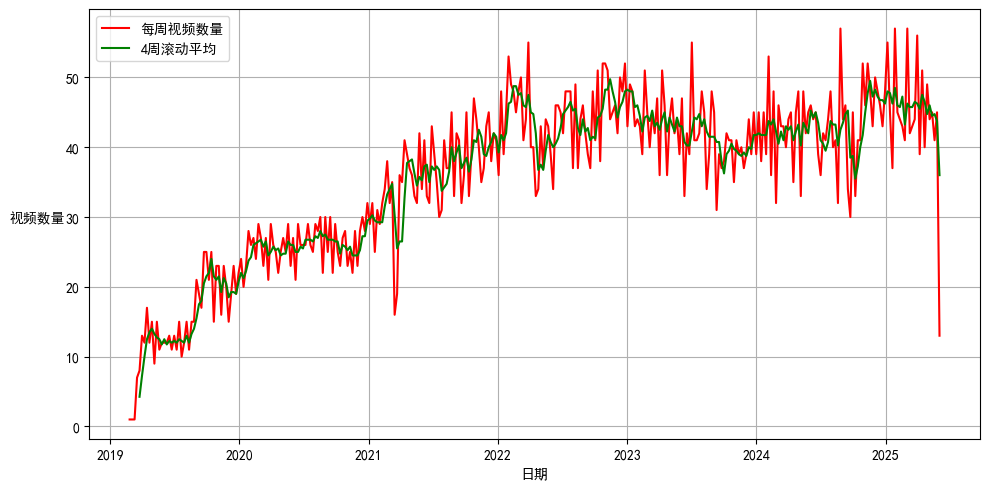

In [19]:
df = data.copy()
df['pudate']=pd.to_datetime(df['pudate'],format='%Y-%m-%d')
df['pudate']=df['pudate'].dt.to_period('W')
tmp=df.groupby('pudate')['pudate'].value_counts()
rolling_avg = tmp.rolling(window=4).mean()

fig = plt.figure(figsize=(10,5))
plt.plot(tmp.index.to_timestamp(),tmp, label='每周视频数量',color ='r',linewidth=1.5)
plt.plot(rolling_avg.index.to_timestamp(), rolling_avg, label='4周滚动平均', color='g',linewidth=1.5)
plt.xlabel('日期')
plt.ylabel('视频数量',rotation=0,labelpad=20)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

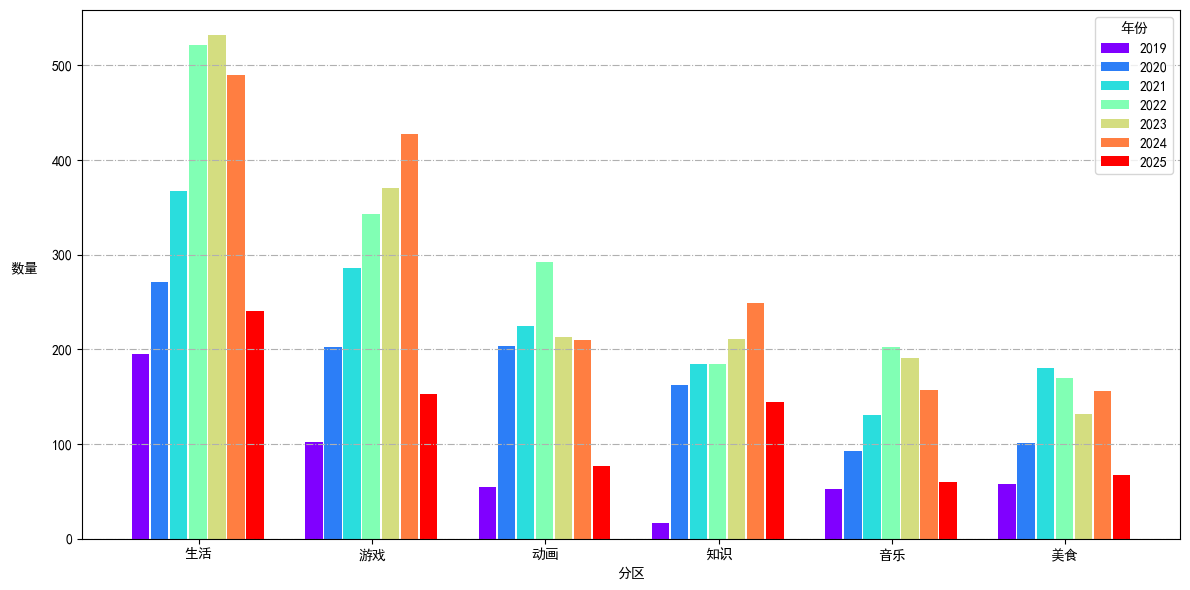

In [20]:
df = data.copy()

df['pudate']=pd.to_datetime(df['pudate'],format='%Y-%m-%d')
df['pudate']=df['pudate'].dt.to_period('Y')
grouped_df = df.groupby(['t_fa', 'pudate']).size().reset_index(name='数量')
categories = grouped_df['t_fa'].unique()
years = grouped_df['pudate'].unique()

data_dict = {(row['t_fa'], row['pudate']): row['数量'] for _, row in grouped_df.iterrows()}

total_counts = {category: 0 for category in categories}

for category in categories:
    total_counts[category] = sum(data_dict.get((category, year), 0) for year in years)

valid_categories = []
for category in categories:
    if all(data_dict.get((category, year), 0) > 0 for year in years):
        valid_categories.append(category)

valid_totals = [(category, total_counts[category]) for category in valid_categories]
top6_categories = sorted(valid_totals, key=lambda x: x[1], reverse=True)[:6]

top6_categories_names = [item[0] for item in top6_categories]

counts = np.zeros((len(top6_categories_names), len(years)))

for i, category in enumerate(top6_categories_names):
    for j, year in enumerate(years):
        counts[i, j] = data_dict.get((category, year), 0)

bar_width = 0.1
spacing_between_bars = 0.01
spacing_between_groups = 0.3

x = np.arange(len(top6_categories_names))

colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))

plt.figure(figsize=(12, 6))

for i, (year, color) in enumerate(zip(years, colors)):
    if year in grouped_df['pudate'].values:
        plt.bar(
            x + i * (bar_width + spacing_between_bars) + spacing_between_groups * (len(years) - 1) / 2,
            counts[:, i], 
            width=bar_width,
            label=str(year),
            color=color
        )

plt.xlabel('分区')
plt.xticks(x + spacing_between_groups * (len(years)+1)/2 +spacing_between_bars * (len(years))/2, top6_categories_names)
plt.ylabel('数量',rotation=0,labelpad=20)
plt.legend(title='年份')
plt.tight_layout()
plt.grid(axis='y',linestyle='-.')
plt.show()

In [21]:
data.columns

Index(['Unnamed: 0', 'date_name', 'aid', 'tid', 'tname', 'title', 'duration',
       'owner_mid', 'owner_name', 'view', 'danmaku', 'reply', 'favorite',
       'coin', 'share', 'like', 'short_link', 'pub_location', 'pubdate',
       'rcmd_reason', 'desc', 't_fa', 'pudate'],
      dtype='object')

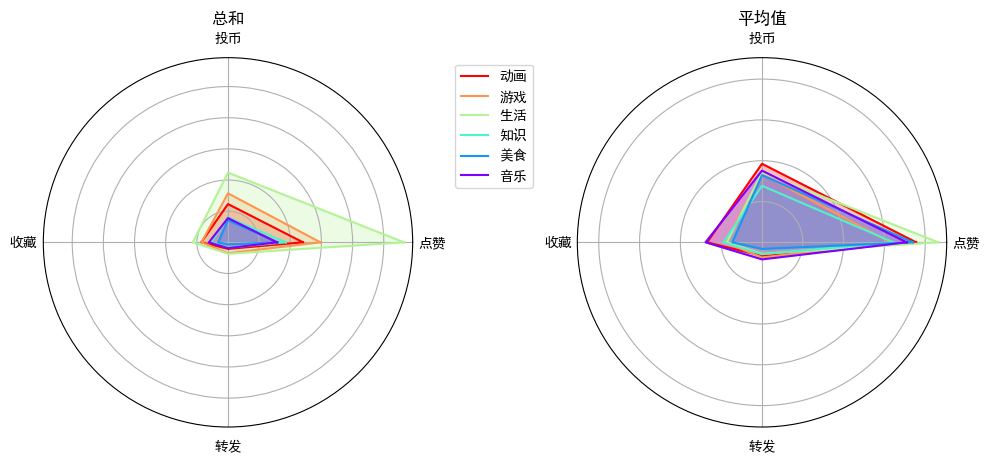

In [22]:
df = data.copy()

partition_count = df['t_fa'].value_counts()

top_partitions = partition_count.nlargest(6).index

top_df = df[df['t_fa'].isin(top_partitions)]

categories = ['like', 'coin', 'favorite', 'share']
total_values = top_df.groupby('t_fa')[categories].sum()
average_values = top_df.groupby('t_fa')[categories].mean()
categories = ['点赞', '投币', '收藏', '转发']
def plot_radar(ax, data, categories, title, colors):
    num_vars = len(categories)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    data = pd.concat([data, data.iloc[[0]]])
    angles += angles[:1]

    for i in range(data.shape[0] - 1):
        current_values = data.iloc[i].tolist() + [data.iloc[i, 0]]

        ax.fill(angles, current_values, alpha=0.25, color=colors[i])
        ax.plot(angles, current_values, label=data.index[i], color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_yticklabels([])
    ax.set_xticklabels(categories)
    ax.set_title(title)

colors = plt.cm.rainbow(np.linspace(1,0, total_values.shape[0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(polar=True))

plot_radar(ax1, total_values, categories, '总和', colors)

plot_radar(ax2, average_values, categories, '平均值', colors)

plt.legend(loc='upper left', bbox_to_anchor=(-0.35, 1))
plt.tight_layout()
plt.show()

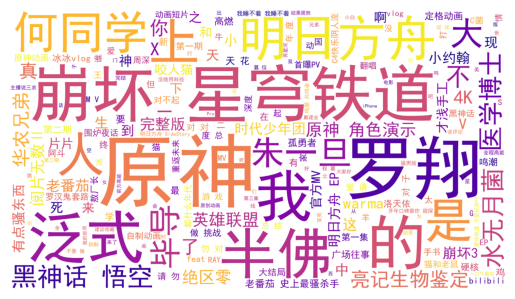

In [23]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = data['title'].dropna().sum()

font_path = 'C:/Windows/Fonts/simhei.ttf'

wordcloud = WordCloud(font_path=font_path, 
                      width=1600, 
                      height=900, 
                      background_color='white',
                      colormap='plasma'
                     ).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

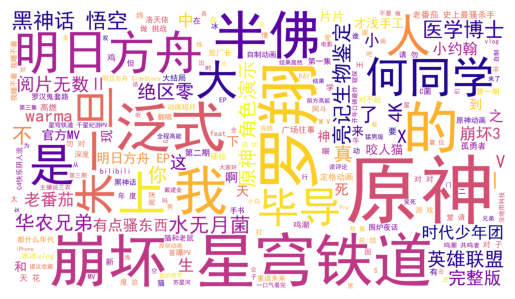

In [24]:
text = data['title'].dropna().sum()

font_path = 'C:/Windows/Fonts/simhei.ttf'

wordcloud = WordCloud(font_path=font_path, 
                      width=1600, 
                      height=900, 
                      background_color='white',
                      colormap='plasma'
                     ).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

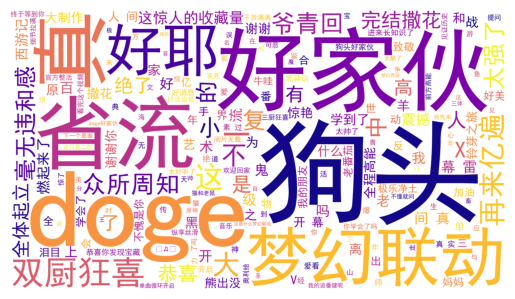

In [25]:
text = data['rcmd_reason'].dropna().sum()

font_path = 'C:/Windows/Fonts/simhei.ttf'

wordcloud = WordCloud(font_path=font_path, 
                      width=1600, 
                      height=900, 
                      background_color='white',
                      colormap='plasma'
                     ).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()